# Import libs

In [229]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import giotto
import sklearn as skl
import plotly
import seaborn as sns
sns.set()

import plotting
import topo

from scipy import signal
from giotto.time_series import Resampler, TakensEmbedding
from giotto.homology import VietorisRipsPersistence
from giotto.diagrams import Filtering, PairwiseDistance, BettiCurve, PersistenceLandscape, Amplitude, HeatKernel
from giotto.diagrams._utils import _subdiagrams
from giotto.pipeline import Pipeline
from sklearn.manifold import smacof
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score, f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import data

In [668]:
x = pd.read_csv('training_un7FCmp.csv')
y = pd.read_csv('target_ATndViR.csv')
xtest = pd.read_csv('input_test_YW07KeM.csv')

x_nid = x[['neuron_id']]
y_label = y[['TARGET']].rename(columns={'TARGET': 'label'})

xy = x.merge(y, on='ID')

npx = x.values
npy = y.values
npx_test = xtest.values

intervals = npx[:, 3:] - npx[:, 2:-1]
intervals_test = npx_test[:,3:] - npx_test[:, 2:-1]

def intervals_to_df(intervals):
    return pd.DataFrame(data=intervals, columns=pd.Index(['interval_%s' % n for n in range(49)])).stack().reset_index().rename(columns={'level_0':'id', 'level_1': 'time', 0:'x'})

df_intervals = intervals_to_df(intervals)
df_intervals_test = intervals_to_df(intervals_test)

# Stats

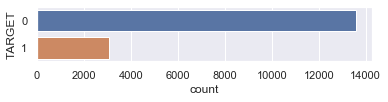

Mean labels balance (0 over 1): 4.439829954218443
# of unique neurons (train): 458
# of unique neurons (test): 113
Train size: 16635
Test size: 11969
Average # of samples per neuron: 36
Average # of samples per neuron in test: 105
Samples per neuron distribution in train and test


<Figure size 1440x144 with 0 Axes>

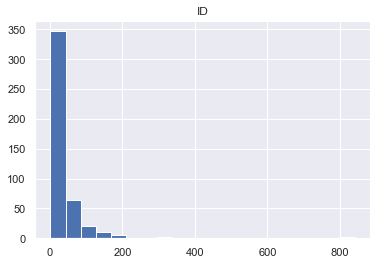

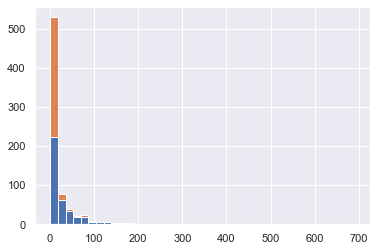

<Figure size 1440x144 with 0 Axes>

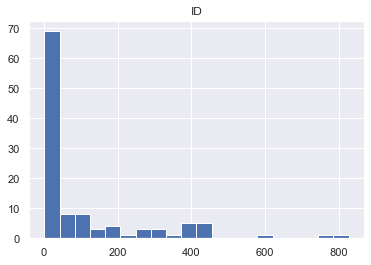

In [708]:
plt.figure(figsize=(6, 1))
sns.countplot(y="TARGET", data=xy)
plt.show()
target_cnt = xy.groupby('TARGET').count()
label_0_cnt = target_cnt.ID[0]
label_1_cnt = target_cnt.ID[1]
print(f'Mean labels balance (0 over 1): {label_0_cnt / label_1_cnt}')

nunique_nid = x.neuron_id.nunique()
nunique_nid_test = xtest.neuron_id.nunique()
print(f'# of unique neurons (train): {nunique_nid}')
print(f'# of unique neurons (test): {nunique_nid_test}')

train_len = len(x)
test_len = len(xtest)

print(f'Train size: {train_len}')
print(f'Test size: {test_len}')

print(f'Average # of samples per neuron: {int(train_len / nunique_nid)}')
print(f'Average # of samples per neuron in test: {int(test_len / nunique_nid_test)}')

print('Samples per neuron distribution in train and test')
plt.figure(figsize=(20, 2))
xy.groupby(['neuron_id']).count()[['ID']].hist(bins=20)
plt.show()
x_multi = [xy[xy.TARGET == n].groupby(['neuron_id']).count()[['ID']].values.flatten() for n in [0, 1]] 
plt.hist(x_multi, 40, stacked=True)
plt.show()
plt.figure(figsize=(20, 2))
xtest.groupby('neuron_id').count()[['ID']].hist(bins=20) #.boxplot(vert=False)
plt.show()

In [686]:
xy[xy.TARGET == 1].groupby(['neuron_id']).count()[['ID']].values.flatten().sum()

3058

In [687]:
xy[xy.TARGET == 0].groupby(['neuron_id']).count()[['ID']].values.flatten().sum()

13577

In [704]:
xy.groupby(['neuron_id']).count()[['ID']].values.flatten().sum()

16635

# Time-series visualisation

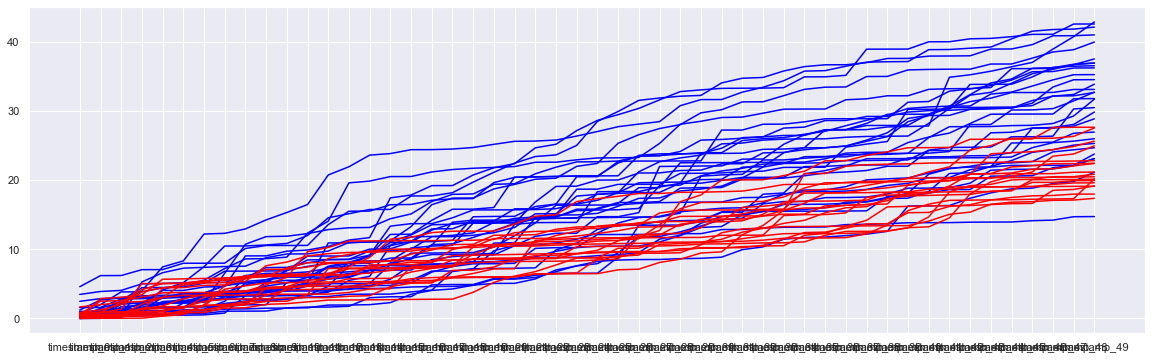

Random neurons


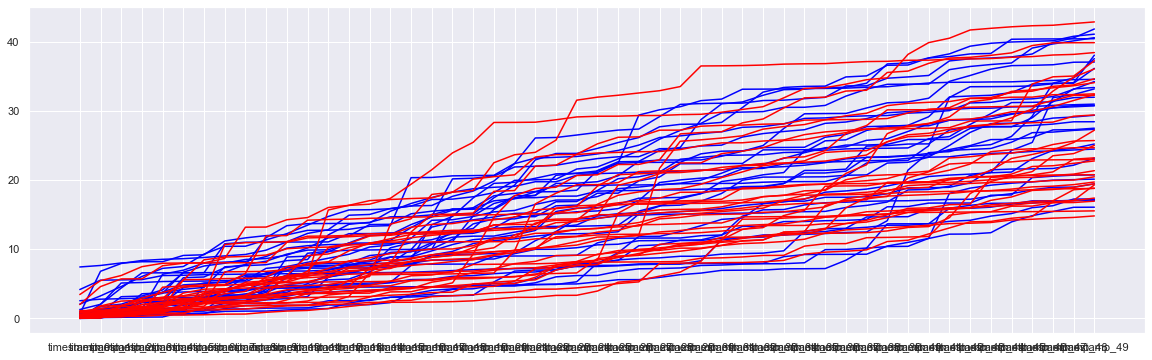

In [821]:
neuron_id = 596
# 596  = good sep
# 6156 = messy
# 2341 = ultra messy
# 7770 = good separation on 30 samples, takes time
# red:1, blue:0

nid_filter = x_nid.neuron_id == neuron_id

n_ts = 30
topo.plot_raw_ts(xy, neuron_id, n_ts, False)

print('Random neurons')
topo.plot_raw_ts(xy, -1, n_ts)

# Preprocessing

## KDE

Standard dev: 3.3333333333333335


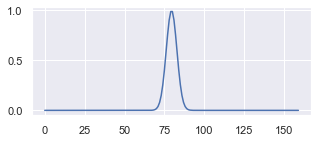

Max last spike timestamp: 430
Right limit: 600


In [805]:
scale = 10
bigm = 16 * scale # Number of points in the output window #good: 32k, 32
rel_std = 48
std = bigm/rel_std
print(f'Standard dev: {std}')
window = signal.gaussian(bigm, std=std)
plt.figure(figsize=(5, 2))
plt.plot(window)
plt.show()

# Rescaling to work with integers
max_last_ts = int(xy.timestamp_49.max() * scale)
right_lim = int(np.ceil(x.values[:, -1].max() / 10 + 1) * 10 * scale)
print(f'Max last spike timestamp: {max_last_ts}')
print(f'Right limit: {right_lim}')

Creating gaussian spikes
Resampling
Plotting gaussian spikes


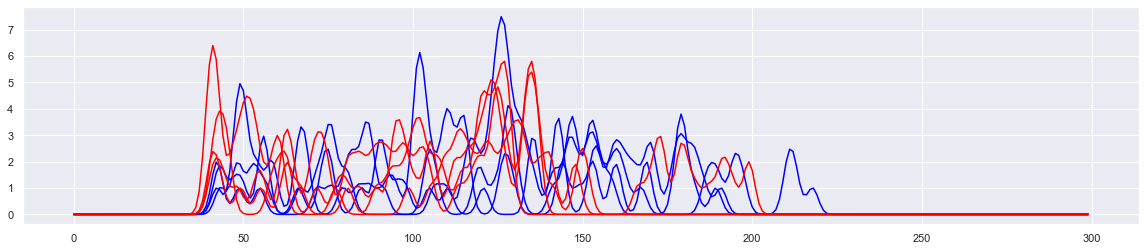

Plotting gaussian spikes sum


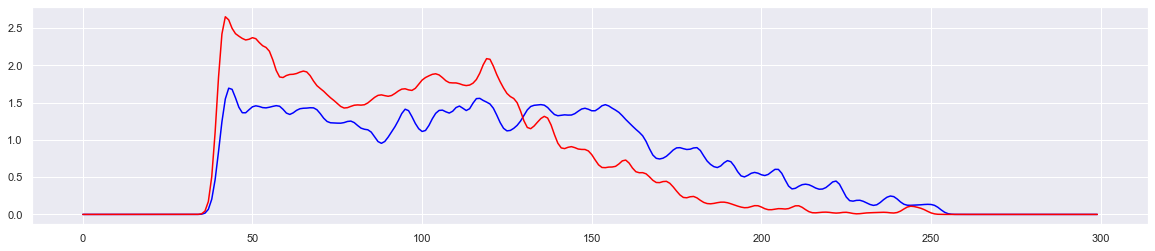

CPU times: user 839 ms, sys: 21.7 ms, total: 861 ms
Wall time: 859 ms


In [809]:
%%time
samples_per_label = 30 #150
full_dataset = False
plot_sum = True
plot_spikes = True

# filter by neuron_id
if full_dataset:
    xy_filtered = xy
else:
    xy_filtered = xy[nid_filter]

x_np = xy_filtered.values[:, 2:-1]
y_np = xy_filtered.values[:, -1:]

n_curves = 3
# topo.plot_raw_ts(xy, neuron_id, n_curves, separate=False)

print('Creating gaussian spikes')
x_gaus = topo.gaus_kde(x_np, window, right_lim, bigm, scale)

print('Resampling')
period = 2
resamp = Resampler(period=period)
x_resamp = resamp.fit_transform(x_gaus.T).T

if plot_spikes:
    print('Plotting gaussian spikes')
    topo.plot_gaus_kde(x_resamp, y_np, 4, 4, samefig=True)

if plot_sum:
    print('Plotting gaussian spikes sum')
    topo.plot_gaus_kde_sum(x_resamp, y_np, xy_filtered, scale)

In [188]:
# x_resamp = intervals

In [810]:
print(f'Number of points before resampling: {x_gaus.shape[1]}')
print(f'Number of points after resampling: {x_resamp.shape[1]}')

Number of points before resampling: 600
Number of points after resampling: 300


# Extract topological features

## Apply TDA pipeline

### Takens embedding

In [852]:
x_tak.shape

(16635, 49, 1)

In [834]:
np.expand_dims(intervals[nid_filter], axis=2).shape

(103, 49, 1)

In [776]:
print('Creating Takens Embedding')
te = TakensEmbedding(time_delay=1, dimension=3, parameters_type='fixed')
x_tak = np.apply_along_axis(te.fit_transform, 1, x_resamp)

Creating Takens Embedding


In [851]:
x_tak = np.expand_dims(intervals, axis=2)

### Persistence diagrams

In [853]:
%%time
compute_pd = True
save_pd = False
load_pd = False
max_edge_length=20

if compute_pd:
    print('Creating V-R Persistence Diagrams')
    homology_dimensions = [0, 1]
    vrp = VietorisRipsPersistence(max_edge_length=20, homology_dimensions=homology_dimensions, n_jobs=-1)
    x_vrpd = vrp.fit_transform(x_tak)
    
if load_pd:
    # Load precomputed x_vrpd on the whole dataset
    x_vrpd = np.load('x_vrpd_4.npy')
    
if save_pd:
    np.save(f'x_vrpd_m{bigm}_rs{rel_std}_r{period}_mel{max_edge_length}.npy', x_vrpd)

Creating V-R Persistence Diagrams
CPU times: user 4.36 s, sys: 593 ms, total: 4.95 s
Wall time: 9.21 s


### Pairwise distances, MDS

In [840]:
%%time
filter_diagrams = False
pw_distances = True

# need scaling first
if filter_diagrams:
    print('Filtering diagrams')
    ftr = Filtering(homology_dimensions=homology_dimensions, epsilon=0.01)
    x_vrpd = ftr.fit_transform(x_vrpd)

if pw_distances:
    print('Compute pairwise distances')
    pwd = PairwiseDistance(metric='betti', n_jobs=-1) # betti, heat > landscape (wasserstein non symmetric)
    x_dists = pwd.fit_transform(x_vrpd)

    print('Plotting betti distances')
    x_mds = smacof(x_dists, n_components=2, n_jobs=-1)
    plt.figure(figsize=(5, 5))
    plt.scatter(x_mds[0][y_0, 0], x_mds[0][y_0, 1], c='blue')
    plt.scatter(x_mds[0][y_1, 0], x_mds[0][y_1, 1], c='red')
    plt.show()

    print('Compute pairwise distances')
    pwd = PairwiseDistance(metric='heat', n_jobs=-1) # betti, heat > landscape (wasserstein non symmetric)
    x_dists = pwd.fit_transform(x_vrpd)

    print('Plotting heat distances')
    x_mds = smacof(x_dists, n_components=2, n_jobs=-1)
    plt.figure(figsize=(5, 5))
    plt.scatter(x_mds[0][y_0, 0], x_mds[0][y_0, 1], c='blue')
    plt.scatter(x_mds[0][y_1, 0], x_mds[0][y_1, 1], c='red')
    plt.show()

Compute pairwise distances
Plotting betti distances


NameError: name 'y_0' is not defined

<Figure size 360x360 with 0 Axes>

### Betti curves

In [854]:
%%time
n_values_bc = 2000
bc = BettiCurve(n_values=n_values_bc, n_jobs=-1)
bcs = bc.fit_transform(x_vrpd)
# plotting.plot_betti_surfaces(bcs)

CPU times: user 1.23 s, sys: 1.49 s, total: 2.71 s
Wall time: 6.74 s


In [855]:
X_betti_0_full = pd.DataFrame(bcs[:, 0])
X_betti_1_full = pd.DataFrame(bcs[:, 1])

## Sub-features experiments

### Plot betti curves

In [856]:
df_0 = X_betti_0_full.rename_axis('sample').reset_index().melt(id_vars=['sample'], var_name='eps', value_name='betti_number_0').set_index(['sample', 'eps'], append=True)
df_1 = X_betti_1_full.rename_axis('sample').reset_index().melt(id_vars=['sample'], var_name='eps', value_name='betti_number_1').set_index(['sample', 'eps'], append=True)
melted_bn = pd.concat([df_0, df_1], axis=1).reset_index(['sample', 'eps']).merge(x_nid.join(y_label).reset_index(drop=True).rename_axis('sample').reset_index())

/Users/philippenguyen/code/topollini/venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



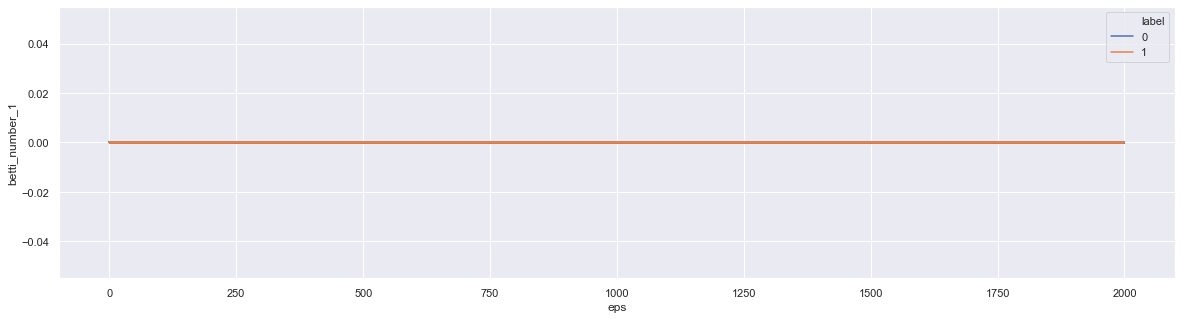

In [857]:
melted_bn_nid = melted_bn[melted_bn.neuron_id == neuron_id]
melted_bn1_nid = melted_bn_nid #[melted_bn.time < 500]
plt.figure(figsize=(20, 5))
sns.lineplot(x="eps", y="betti_number_1",
             hue="label", units='sample', estimator=None,
             data=melted_bn1_nid)
plt.show()

In [858]:
time_range_0 = 80
time_range_1 = 150
#bn0_df_label = pd.DataFrame(bcs[:, 0, :time_range_0]).join(y_label)
#bn1_df_label = pd.DataFrame(bcs[:, 1, :time_range_1]).join(y_label)
bn0_df_label = X_betti_0_full.join(y_label)
bn1_df_label = X_betti_1_full.join(y_label)

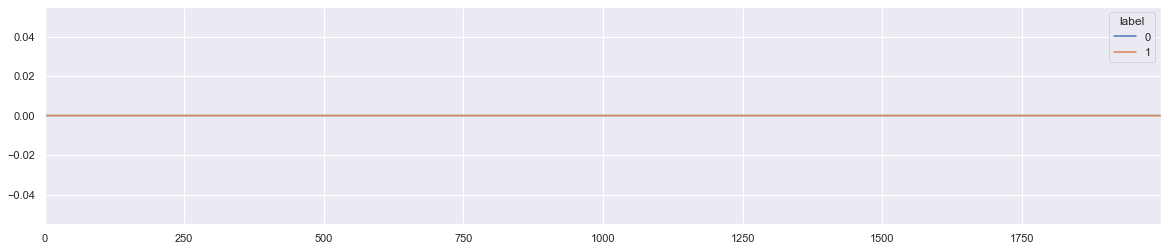

In [859]:
bn1_df_label[nid_filter].groupby('label').mean().T.plot(figsize=(20, 4))
plt.show()

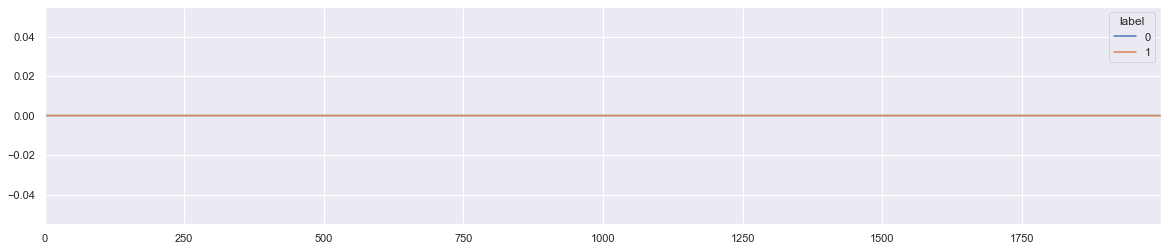

In [860]:
bn1_df_label.groupby('label').apply(lambda x: x.sample(10)).reset_index(drop=True).groupby('label').mean().T.plot(figsize=(20, 4))
plt.show()

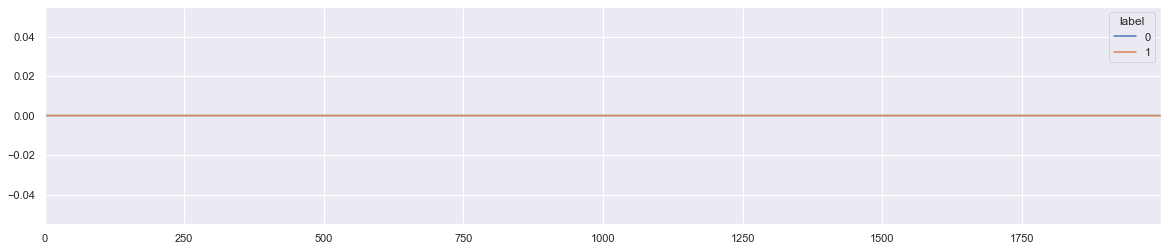

In [861]:
bn1_df_label.groupby('label').mean().T.plot(figsize=(20, 4))
plt.show()

/Users/philippenguyen/code/topollini/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



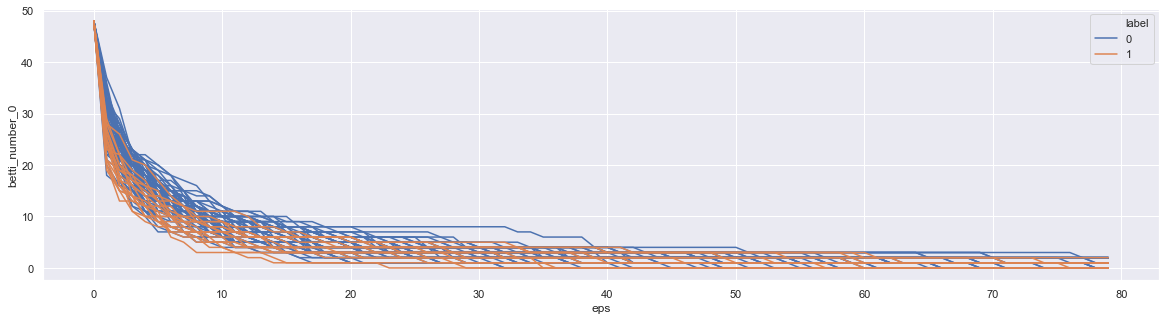

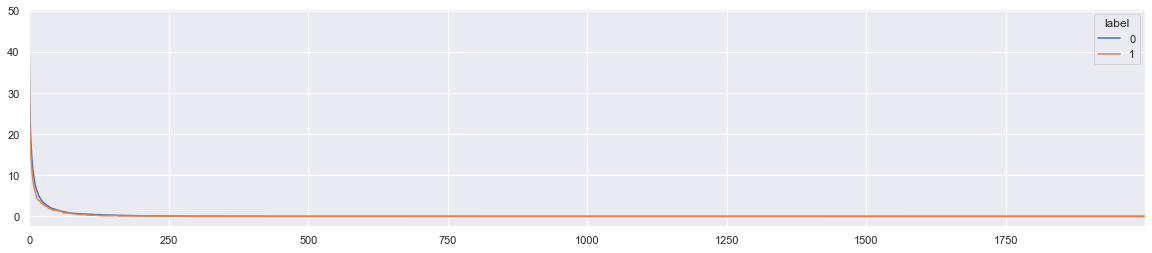

In [862]:
melted_bn0_nid = melted_bn_nid[melted_bn.eps < time_range_0]
plt.figure(figsize=(20, 5))
sns.lineplot(x="eps", y="betti_number_0",
             hue="label", units='sample', estimator=None,
             data=melted_bn0_nid)
plt.show()
bn0_df_label[nid_filter].groupby('label').mean().T.plot(figsize=(20, 4))
plt.show()

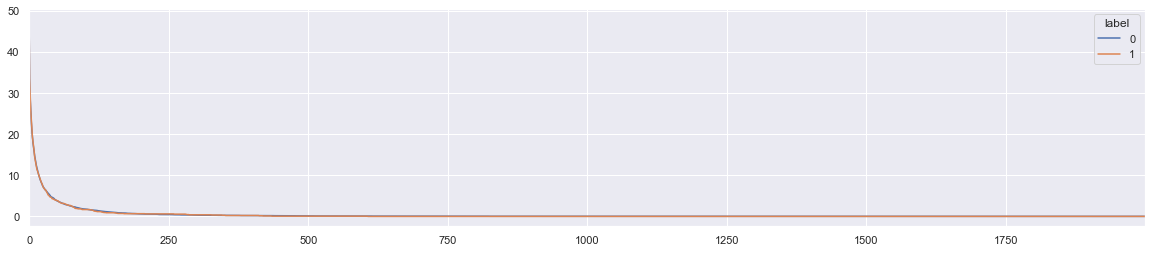

In [850]:
bn0_df_label.groupby('label').mean().T.plot(figsize=(20, 4))
plt.show()

### Area under the curve

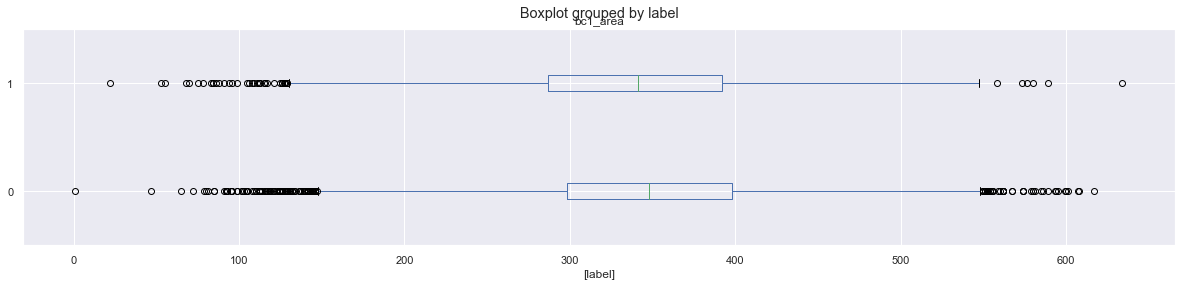

In [329]:
sum_range = 120 #30
X_betti_1 = pd.DataFrame(bcs[:, 1, 0:sum_range])
X_sum1 = pd.DataFrame(X_betti_1.sum(axis=1), columns=['bc1_area']).join(y_label).join(x_nid)
# X_sum1 = X_sum1[X_sum1.neuron_id == neuron_id]
X_sum1[['bc1_area','label']].boxplot(by='label', vert=False, figsize=(20, 4))
plt.show()

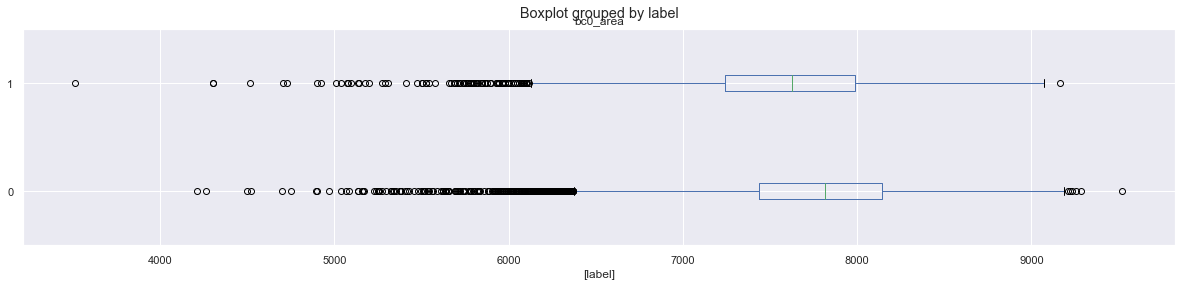

In [330]:
X_betti_0 = pd.DataFrame(bcs[:, 0, 0:60])
X_sum0 = pd.DataFrame(X_betti_0.sum(axis=1), columns=['bc0_area']).join(y_label).join(x_nid)
# X_sum0 = X_sum0[X_sum0.neuron_id == neuron_id]
X_sum0[['bc0_area','label']].boxplot(by='label', vert=False, figsize=(20, 4))
plt.show()

In [228]:
lim_all = 30 #35 dichotomy (17 nid)
X_sum1['manual_clf'] = X_sum1.apply(lambda x: 1.0 if x.bc1_area < lim_all else 0.0, axis = 1)
print(confusion_matrix(X_sum1.manual_clf, X_sum1.label))
print(cohen_kappa_score(X_sum1.manual_clf, X_sum1.label))

[[8209 1617]
 [5368 1441]]
0.05141673366534982


In [338]:
lim_all = 7300 #1167 dichotomy (1250 for nid)
X_sum0['manual_clf'] = X_sum0.apply(lambda x: 1.0 if x.bc0_area < lim_all else 0.0, axis = 1)
print(confusion_matrix(X_sum0.manual_clf, X_sum0.label))
print(cohen_kappa_score(X_sum0.manual_clf, X_sum0.label))
print(f1_score(X_sum0.manual_clf, X_sum0.label))

[[11043  2197]
 [ 2534   861]]
0.09103121919280177
0.26685262668526266


In [231]:
bc_area = X_sum1[['bc1_area']].join(X_sum0[['bc0_area']])

### Adcock et al. Coordinates

In [339]:
def yi_minus_xi(X):
    return X[:, :, 1] - X[:, :, 0]

Pxi(yi − xi)

In [340]:
def feature_1(X, dim):
    X = _subdiagrams(X, [dim])
    return np.sum((X[:, :, 0] * yi_minus_xi(X)), axis=1) / X.shape[1]

P(ymax − yi)(yi − xi)

In [341]:
def feature_2(X, dim):
    X = _subdiagrams(X, [dim])
    return np.sum((np.max(X[:, :, 1], axis=1).reshape((X.shape[0], 1)) - X[:, :, 1]) * (yi_minus_xi(X)), axis=1) / X.shape[1]

Pxi2(yi − xi)4

In [342]:
def feature_3(X, dim):
    X = _subdiagrams(X, [dim])
    return np.sum(((X[:, :, 0]**2) * (yi_minus_xi(X)**4)), axis=1) / X.shape[1]

P(ymax − yi)2(yi − xi)4

In [343]:
def feature_4(X, dim):
    X = _subdiagrams(X, [dim])
    return np.sum(((np.max(X[:, :, 1], axis=1).reshape((X.shape[0], 1)) - X[:, :, 1])**2) * (yi_minus_xi(X)**4), axis=1) / X.shape[1]

max{(yi − xi)}

In [344]:
def feature_5(X, dim):
    X = _subdiagrams(X, [dim])
    return np.max(yi_minus_xi(X), axis=1) / X.shape[1]

In [345]:
fts_func = [feature_1, feature_2, feature_3, feature_4, feature_5]
fts = {}
for feature_number in range(5):
    for dim in range(2):
        fts[f'f{feature_number}_d{dim}'] = fts_func[feature_number](x_vrpd, dim)

In [346]:
tropical = pd.DataFrame(fts)

### Landscapes (WIP)

In [139]:
pl = PersistenceLandscape(n_jobs=-1, n_layers=3)
x_pl = pl.fit_transform(x_vrpd_full)

In [124]:
x_pl.shape

(16635, 2, 1, 100)

### Amplitude

In [347]:
amp = Amplitude(metric='heat', metric_params=None, order=2.0, n_jobs=-1)
# x_amp = amp.fit_transform(x_vrpd)

In [348]:
amps = {}
for metric in ['bottleneck', 'wasserstein', 'landscape', 'betti', 'heat']:
    print(metric)
    amp = Amplitude(metric=metric, metric_params=None, n_jobs=-1)
    x_amp = amp.fit_transform(x_vrpd)
    amps[metric] = x_amp.ravel()
    # plt.figure(figsize=(20, 6))
    # pd.DataFrame(amps[metric], columns=[metric]).join(y_label).groupby('label')[metric].plot.kde()
    # plt.show()
# .boxplot(by='label')

bottleneck
wasserstein
landscape
betti
heat


In [349]:
amplitudes = pd.DataFrame(amps)

### Gaussian kernel (WIP)

In [132]:
hk = HeatKernel(8., n_values=100, n_jobs=-1)
x_hk = hk.fit_transform(x_vrpd_full)

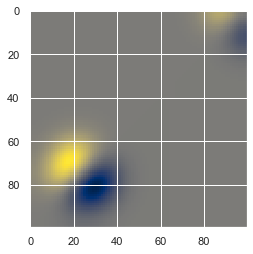

In [134]:
plt.imshow(x_hk[0, 1], cmap='cividis')
plt.show()

### Moments

In [350]:
m_1 = np.sum(normalize(bcs[:, 1], norm='max', axis=1) * np.power(np.arange(2000), 1), axis=1)
m_2 = np.sum(normalize(bcs[:, 1], norm='max', axis=1) * np.power(np.arange(2000), 2), axis=1)

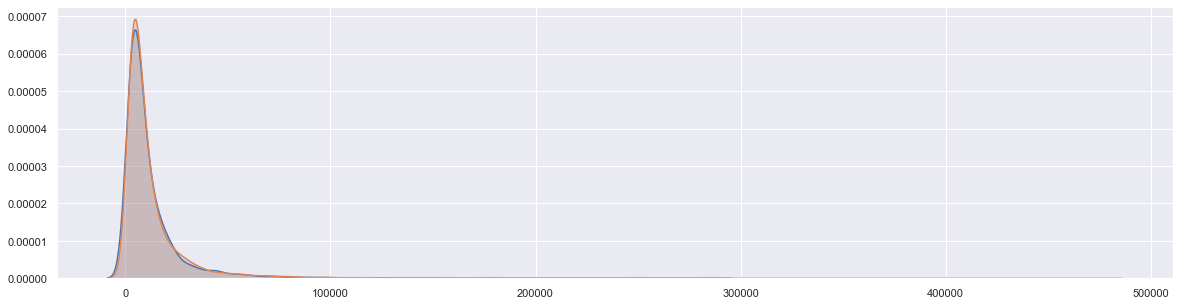

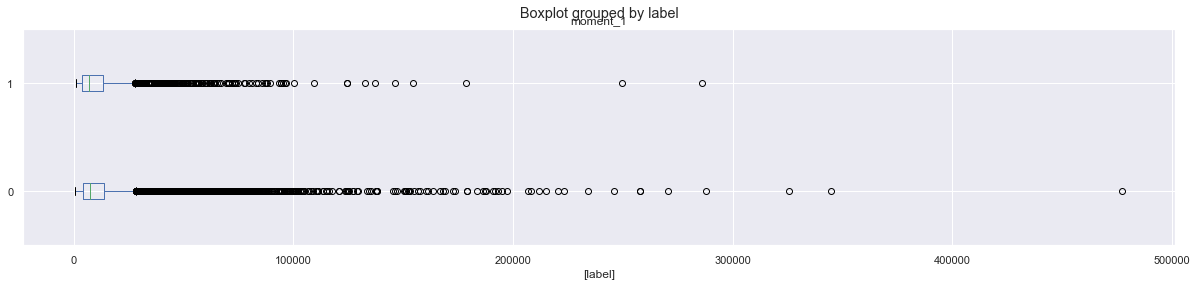

In [351]:
plt.figure(figsize=(20, 5))
select_nid = x_nid.neuron_id == neuron_id

sns.kdeplot(pd.DataFrame(m_1, columns=['moment_1'])[y_label.label==1].moment_1.values, shade=True, gridsize=1000)
sns.kdeplot(pd.DataFrame(m_1, columns=['moment_1'])[y_label.label==0].moment_1.values, shade=True, gridsize=1000)
plt.show()

pd.DataFrame(m_1, columns=['moment_1']).join(y_label).boxplot(by='label', vert=False, figsize=(20, 4))
plt.show()

In [47]:
mdf1 = pd.DataFrame(m_1, columns=['moment_1']).join(y_label)[x_nid.neuron_id == neuron_id]
thm1 = 19000
mdf1['manual_clf'] = mdf1.apply(lambda x: 1.0 if x.moment_1 > thm1 else 0.0, axis = 1)
print(confusion_matrix(mdf1.manual_clf, mdf1.label))
print(cohen_kappa_score(mdf1.manual_clf, mdf1.label))

[[75  9]
 [41 19]]
0.2268041237113403


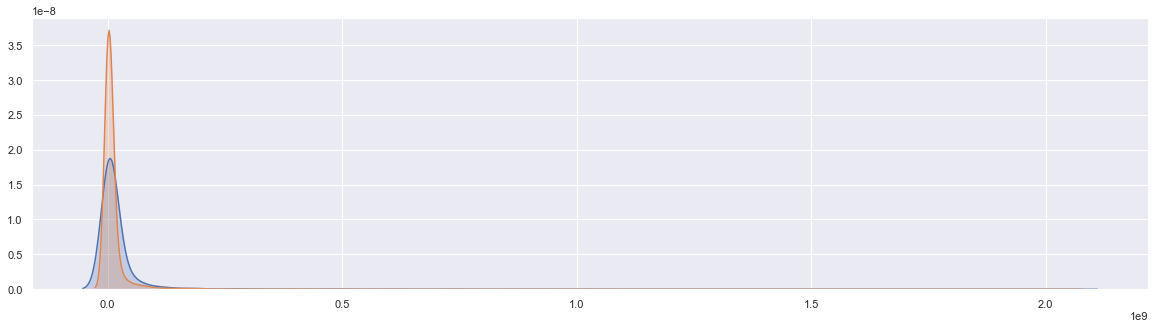

In [44]:
plt.figure(figsize=(20, 5))

sns.kdeplot(pd.DataFrame(m_2, columns=['moment_2'])[y_label.label==1].moment_2.values, shade=True, gridsize=1000)
sns.kdeplot(pd.DataFrame(m_2, columns=['moment_2'])[y_label.label==0].moment_2.values, shade=True, gridsize=1000)
plt.show()


In [352]:
moments = {
    'moment_1': m_1,
    'moment_2': m_2,
}
moments_df = pd.DataFrame(moments)

### Cumulative sum

In [367]:
cumsum_range = 200
X_betti_cs_1 = pd.DataFrame(bcs[:, 1, 25:cumsum_range])

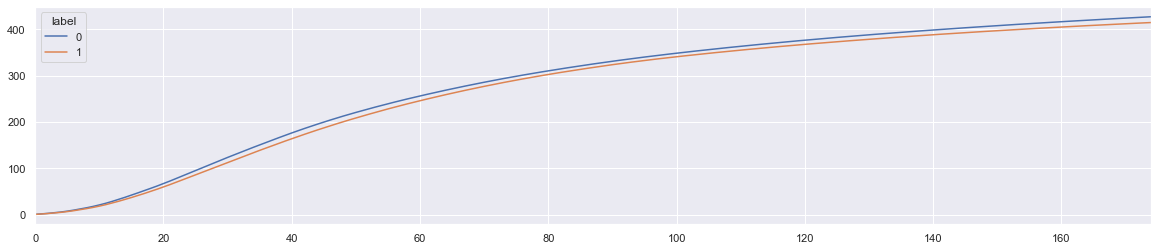

In [368]:
X_cumsum = X_betti_cs_1.cumsum(axis=1).join(y_label).join(x_nid) #[x_nid.neuron_id == neuron_id]
X_cumsum.groupby('label').mean().drop('neuron_id', axis=1).T.plot(figsize=(20, 4))
plt.show()

In [57]:
mmm = 0
for j in range(110, 130):
    for i in range(60, 80):
        X_cumsum['manual_clf'] = X_cumsum.apply(lambda x: 1.0 if x[j] < i else 0.0, axis = 1)
        # print(confusion_matrix(X_cumsum.manual_clf, X_cumsum.label))
        # print(cohen_kappa_score(X_cumsum.manual_clf, X_cumsum.label))
        if cohen_kappa_score(X_cumsum.manual_clf, X_cumsum.label) > mmm:
            mmm = cohen_kappa_score(X_cumsum.manual_clf, X_cumsum.label)
            besti = i
            bestj = j
            
print(mmm)
print(besti)
print(bestj)

0.13776448330640623
69
129


In [58]:
X_cumsum['manual_clf'] = X_cumsum.apply(lambda x: 1.0 if x[129] < 69 else 0.0, axis = 1)
cohen_kappa_score(X_cumsum.manual_clf, X_cumsum.label)

0.13776448330640623

# Classification

In [353]:
# Join all topological features
topo_features = bc_area.join(tropical).join(amplitudes).join(moments_df) #.join(X_betti_cs_1[[129]]).drop(columns=['f0_d0', 'f2_d0'])

In [354]:
# Rescaling
scaler = MinMaxScaler()
topo_features[topo_features.columns] = scaler.fit_transform(topo_features[topo_features.columns])
topo_features.head()

,bc1_area,bc0_area,f0_d0,f0_d1,f1_d0,f1_d1,f2_d0,f2_d1,f3_d0,f3_d1,f4_d0,f4_d1,bottleneck,wasserstein,landscape,betti,heat,moment_1,moment_2
0,0.011952,0.351785,0.0,0.356877,0.479374,0.492856,0.0,2.578451e-02,0.034212,0.031828,0.567717,0.485781,0.560010,0.541252,0.437155,0.642426,0.596544,0.174992,0.096955
1,0.127490,0.312468,0.0,0.045798,0.040687,0.064148,0.0,8.423089e-06,0.000011,0.000068,0.083135,0.134437,0.206593,0.235754,0.097501,0.745599,0.803709,0.024246,0.002493
2,0.302789,0.732023,0.0,0.052908,0.111024,0.140195,0.0,5.076848e-05,0.000096,0.000229,0.187723,0.161163,0.213275,0.286596,0.111373,0.718742,0.863528,0.012043,0.002079
3,0.338645,0.347646,0.0,0.019207,0.045977,0.033582,0.0,2.938274e-07,0.000007,0.000012,0.086703,0.047044,0.196494,0.266714,0.085961,0.887041,0.754757,0.007523,0.000599
4,0.306773,0.413864,0.0,0.090503,0.133535,0.157969,0.0,1.419635e-04,0.000424,0.001792,0.216700,0.182950,0.149556,0.240337,0.058912,0.681261,0.729469,0.038479,0.008607


In [361]:
# Join with tsfresh features
tsfresh_features = pd.read_pickle("tsfresh_features.pkl")
topo_features = topo_features.join(tsfresh_features)
# topo_features = tsfresh_features

In [362]:
# Under-sampling
tf_us = topo_features.join(y_label).groupby('label').head(3000)

In [363]:
X_train, X_test, y_train, y_test = train_test_split(tf_us.drop(columns=['label']), tf_us.label.values, test_size=0.2, random_state=42)

In [364]:
log_clf = LogisticRegression(solver="liblinear")
log_clf.fit(X_train, y_train)
preds = log_clf.predict(X_test)
print('\nLogisticRegression')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))

sgd_clf = SGDClassifier(n_jobs=-1, max_iter=2000)
sgd_clf.fit(X_train, y_train)
preds = sgd_clf.predict(X_test)
print('\nSGDClassifier')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))

svc = LinearSVC(max_iter=5000)
# svc.fit(X_train, y_train)
# preds = svc.predict(X_test)
# print('\nLinearSVC')
# print(confusion_matrix(y_test, preds))
# print(cohen_kappa_score(y_test, preds))

mlp = MLPClassifier(max_iter=300)
mlp.fit(X_train, y_train)
preds = mlp.predict(X_test)
print('\nMLPClassifier')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))

rf = RandomForestClassifier(n_estimators=100) #, class_weight={0: 4.439, 1: 1}
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
print('\nRandomForestClassifier')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))
print(f1_score(y_test, preds))

gnb = GaussianNB()
gnb.fit(X_train, y_train)
preds = gnb.predict(X_test)
print('\nGNB')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))

kn = KNeighborsClassifier(3)
kn.fit(X_train, y_train)
preds = kn.predict(X_test)
print('\nKNN')
print(confusion_matrix(y_test, preds))
print(cohen_kappa_score(y_test, preds))


LogisticRegression
[[416 207]
 [208 369]]
0.3072711490952795

SGDClassifier
[[579  44]
 [436 141]]
0.1782111826054701

MLPClassifier
[[326 297]
 [178 399]]
0.21315928968990183

RandomForestClassifier
[[422 201]
 [208 369]]
0.3170242965684228
0.6434176111595468

GNB
[[393 230]
 [199 378]]
0.2853652577571463

KNN
[[371 252]
 [241 336]]
0.17770290556093005


In [365]:
preds = rf.predict(topo_features) # .join(tsfresh_features)
ytemp = topo_features.join(y_label).label.values
print(confusion_matrix(ytemp, preds))
print(cohen_kappa_score(ytemp, preds))
print(f1_score(ytemp, preds))


[[10193  3384]
 [  228  2830]]
0.48306728815759425
0.6104400345125107


In [255]:
preds = rf.predict(topo_features) # .join(tsfresh_features)
ytemp = topo_features.join(y_label).label.values
print(confusion_matrix(ytemp, preds))
print(cohen_kappa_score(ytemp, preds))

[[10047  3530]
 [  208  2850]]
0.47295239362592545


In [360]:
preds = gs.best_estimator_.predict(topo_features) # .join(tsfresh_features)
ytemp = topo_features.join(y_label).label.values
print(confusion_matrix(ytemp, preds))
print(cohen_kappa_score(ytemp, preds))

ValueError: Number of features of the model must match the input. Model n_features is 229 and input n_features is 18 

In [323]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

model = RandomForestClassifier(random_state=0)

param_dist = {'max_features': ['auto', None],
              'max_depth': [5, 10, 20, 50],
              'n_estimators': [10, 100, 1000]}

scoring = make_scorer(cohen_kappa_score)

gs = GridSearchCV(model, param_grid=param_dist, scoring=scoring, verbose=5, n_jobs=-1, return_train_score=True, cv=5)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 40.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max

In [324]:
gs.best_score_

0.42019394707139257

In [819]:
gs.best_score_

NameError: name 'gs' is not defined

In [333]:
X_train.columns.values

array(['bc1_area', 'bc0_area', 'f0_d1', 'f1_d0', 'f1_d1', 'f2_d1',
       'f3_d0', 'f3_d1', 'f4_d0', 'f4_d1', 'bottleneck', 'wasserstein',
       'landscape', 'betti', 'heat', 'moment_1', 'moment_2', 129,
       'x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0',
       'x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2',
       'x__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0',
       'x__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2',
       'x__quantile__q_0.8',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0',
       'x__number_crossing_m__m_1',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4',
       'x__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4',
       'x__range_count__max_1__min_-1',
       'x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4',
       'x__ratio_beyond_r_sigma__r_0.5', 'x__

In [340]:
pd.DataFrame({'name': X_train.columns.values, 'fi': gs.best_estimator_.feature_importances_}).sort_values(by='fi', ascending=False).name.tolist()

['x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0',
 'x__quantile__q_0.1',
 'x__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0',
 'x__approximate_entropy__m_2__r_0.7',
 'x__minimum',
 'x__approximate_entropy__m_2__r_0.9',
 'x__approximate_entropy__m_2__r_0.5',
 'x__quantile__q_0.2',
 'x__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"intercept"',
 'x__quantile__q_0.3',
 'x__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"stderr"',
 'x__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0',
 'x__autocorrelation__lag_4',
 'x__energy_ratio_by_chunks__num_segments_10__segment_focus_7',
 'x__partial_autocorrelation__lag_8',
 'x__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2',
 'x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4',
 'heat',
 'x__energy_ratio_by_chunks__num_segments_10__segment_focus_8',
 'x__fft_coefficient__coeff_19__attr_"abs"',
 'x__energy_ratio_by_chunks__num_segments_10__segment_focus_4',
 'x__agg_linear_trend

In [331]:
gs.best_estimator_.feature_importances_

array([3.94774019e-03, 4.40114431e-03, 4.21613085e-03, 3.35664010e-03,
       5.03797663e-03, 3.26346096e-03, 3.02174936e-03, 3.60167467e-03,
       3.62084350e-03, 4.52694319e-03, 3.64688143e-03, 4.40406629e-03,
       3.80542841e-03, 5.13358627e-03, 6.15338403e-03, 3.73392309e-03,
       3.65403613e-03, 1.44973156e-03, 1.02583554e-01, 4.71848598e-03,
       4.28235888e-02, 6.28363179e-03, 5.09965001e-03, 4.37996438e-03,
       4.78121721e-03, 2.05319543e-03, 5.11164994e-03, 4.08437320e-03,
       1.06619243e-03, 6.26888971e-03, 2.66994606e-03, 5.51088998e-03,
       1.15650609e-02, 1.31907901e-02, 4.67349029e-03, 4.59412037e-02,
       5.27612594e-03, 1.12917319e-02, 3.97533089e-03, 2.65339863e-03,
       1.24547481e-03, 1.06073046e-03, 1.09649390e-03, 5.56989023e-03,
       1.69889936e-03, 1.65297256e-03, 4.75112477e-03, 2.93618708e-03,
       3.53735603e-03, 4.27623831e-03, 1.01987602e-02, 1.01423707e-03,
       1.01328689e-03, 1.05941394e-03, 1.01642388e-03, 1.32963230e-03,
      

In [343]:
topo_features.columns.values

array(['bc1_area', 'bc0_area', 'f0_d1', 'f1_d0', 'f1_d1', 'f2_d1',
       'f3_d0', 'f3_d1', 'f4_d0', 'f4_d1', 'bottleneck', 'wasserstein',
       'landscape', 'betti', 'heat', 'moment_1', 'moment_2', 129,
       'x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0',
       'x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2',
       'x__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0',
       'x__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2',
       'x__quantile__q_0.8',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0',
       'x__number_crossing_m__m_1',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4',
       'x__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4',
       'x__range_count__max_1__min_-1',
       'x__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4',
       'x__ratio_beyond_r_sigma__r_0.5', 'x__

In [359]:
pd.DataFrame({'name': X_train.columns.values, 'fi': rf.feature_importances_}).sort_values(by='fi', ascending=False).name.tolist()

['bc0_area',
 'bc1_area',
 'f1_d1',
 'heat',
 'betti',
 'f0_d1',
 'f3_d1',
 'moment_1',
 'f4_d1',
 'moment_2',
 'f1_d0',
 'wasserstein',
 'bottleneck',
 'f4_d0',
 'landscape',
 'f3_d0',
 'f2_d1',
 'f2_d0',
 'f0_d0']

# Predict test set

In [ ]:
x_np_test = xtest.values[:, 2:]
x_gaus_test = topo.gaus_kde(x_np_test, window, min_right_lim, bigm, scale)
x_resamp_test = resamp.transform(x_gaus_test.T).T
x_tak_test = np.apply_along_axis(te.transform, 1, x_resamp_test)
homology_dimensions = [0, 1]
vrp = VietorisRipsPersistence(max_edge_length=20, homology_dimensions=homology_dimensions, n_jobs=-1)
x_vrpd_test = vrp.fit_transform(x_tak_test)
bcs_test = bc.transform(x_vrpd_test)

In [371]:
xtest.values[:, 2:]

array([[1.11622511e-02, 2.21067985e-01, 4.30589433e-01, ...,
        2.59233256e+01, 3.42135130e+01, 3.42520100e+01],
       [4.61402240e-01, 1.11827797e+00, 1.70873979e+00, ...,
        1.65826214e+01, 1.69626240e+01, 1.70784531e+01],
       [4.83415808e-01, 5.74965236e-01, 2.16082312e+00, ...,
        2.15396900e+01, 2.29176966e+01, 2.41261541e+01],
       ...,
       [5.63163718e-01, 1.56362464e+00, 1.67787880e+00, ...,
        2.38078937e+01, 2.44255253e+01, 2.52713584e+01],
       [1.05218243e+00, 1.06612689e+00, 1.80568812e+00, ...,
        4.19631181e+01, 4.19831409e+01, 4.20386232e+01],
       [4.84302784e-03, 2.64117074e-02, 3.35899584e-02, ...,
        1.91663019e+01, 1.93628577e+01, 1.93709046e+01]])

In [ ]:
X_betti_1_test = pd.DataFrame(bcs_test[:, 1, 0:sum_range])
X_sum1_test = pd.DataFrame(X_betti_1_test.sum(axis=1), columns=['bc1_area'])
X_betti_0_test = pd.DataFrame(bcs_test[:, 0, 0:60])
X_sum0_test = pd.DataFrame(X_betti_0_test.sum(axis=1), columns=['bc0_area'])

X_sum1_test['manual_clf'] = X_sum1_test.apply(lambda x: 1.0 if x.bc1_area < 40 else 0.0, axis = 1)
X_sum0_test['manual_clf'] = X_sum0_test.apply(lambda x: 1.0 if x.bc0_area < 2545 else 0.0, axis = 1)
bc_area_test = X_sum1_test[['bc1_area']].join(X_sum0_test[['bc0_area']])

fts_test = {}
for feature_number in range(5):
    for dim in range(2):
        fts_test[f'f{feature_number}_d{dim}'] = fts_func[feature_number](x_vrpd_test, dim)
        
tropical_test = pd.DataFrame(fts_test)

amps_test = {}
for metric in ['bottleneck', 'wasserstein', 'landscape', 'betti', 'heat']:
    amp = Amplitude(metric=metric, metric_params=None, n_jobs=-1)
    x_amp_test = amp.fit_transform(x_vrpd_test)
    amps_test[metric] = x_amp_test.ravel()
    
amplitudes_test = pd.DataFrame(amps_test)
    
m_1_test = np.sum(normalize(bcs_test[:, 1], norm='max', axis=1) * np.power(np.arange(2000), 1), axis=1)
m_2_test = np.sum(normalize(bcs_test[:, 1], norm='max', axis=1) * np.power(np.arange(2000), 2), axis=1)
moments_test = {
    'moment_1': m_1_test,
    'moment_2': m_2_test,
}
moments_df_test = pd.DataFrame(moments_test)

X_betti_cs_1_test = pd.DataFrame(bcs_test[:, 1, 25:cumsum_range])
X_cumsum_test = X_betti_cs_1_test.cumsum(axis=1)
X_cumsum_test['manual_clf'] = X_cumsum_test.apply(lambda x: 1.0 if x[129] < 69 else 0.0, axis = 1)



In [219]:
topo_features_test = bc_area_test.join(tropical_test).join(amplitudes_test).join(moments_df_test).join(X_betti_cs_1_test[[129]]).drop(columns=['f0_d0', 'f2_d0'])
topo_features_test[topo_features_test.columns] = scaler.transform(topo_features_test[topo_features_test.columns])

In [328]:
tsfresh_features_test = pd.read_pickle("tsfresh_features_test.pkl")
topo_features_test = topo_features_test.join(tsfresh_features_test)

In [329]:
preds_test = gs.best_estimator_.predict(topo_features_test)
predsdict = {
    'ID': xtest.ID.values,
    'TARGET': preds_test
}

In [330]:
pd.DataFrame(predsdict).to_csv('target_20_11_2019_1.csv', index=False, header=True)

In [428]:
bcs.shape[2]

2000